In [1]:
import os
import sys

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix, f1_score, precision_score, recall_score
from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
import numpy as np
from models import networks
from transformers import BertTokenizer, RobertaTokenizer
from configs.base import Config
root_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

/home/kuhaku/mambaforge-pypy3/envs/3m-ser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter
def calculate_accuracy(y_pred, y_true):
    class_weights = {cls: 1.0/count for cls, count in Counter(y_true).items()}
    wa = balanced_accuracy_score(y_true, y_pred, sample_weight=[class_weights[cls] for cls in y_true])
    ua = accuracy_score(y_true, y_pred)
    return wa, ua

In [3]:
def eval_svm(opt, checkpoint_path, tokenizer, all_state_dict=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = getattr(networks, opt.model_type)(
                num_classes=opt.num_classes,
                num_attention_head=opt.num_attention_head,
                dropout=opt.dropout,
                text_encoder_type=opt.text_encoder_type,
                text_encoder_dim=opt.text_encoder_dim,
                text_unfreeze=opt.text_unfreeze,
                audio_encoder_type=opt.audio_encoder_type,
                audio_encoder_dim=opt.audio_encoder_dim,
                audio_unfreeze=opt.audio_unfreeze,
                audio_norm_type=opt.audio_norm_type,
                fusion_head_output_type=opt.fusion_head_output_type,
            )
    network.to(device)

    # Build dataset
    train_ds, test_ds = build_train_test_dataset(
        opt.data_root,
        opt.batch_size,
        tokenizer,
        opt.audio_max_length,
        text_max_length=opt.text_max_length,
        audio_encoder_type=opt.audio_encoder_type,
    )
    weight = torch.load(checkpoint_path, map_location=torch.device(device))
    if all_state_dict:
        weight = weight['state_dict_network']
    else:
        weight = weight.state_dict()
    
    network.load_state_dict(weight)
    network.eval()
    network.to(device)

    # Get train features
    train_x = []
    train_y = []
    for every_train_list in tqdm(train_ds):
        input_ids, audio, label = every_train_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            feature = network(input_ids,audio)[1]
            train_x.append(feature.detach().cpu().numpy()[0])
            train_y.append(label.detach().cpu().numpy()[0])
    
    # SVM
    clf = svm.SVC()
    clf.fit(train_x, train_y)
    
    y_actu=[]
    y_pred=[]

    for every_test_list in tqdm(test_ds):
        input_ids, audio, label = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            feature = network(input_ids,audio)[1]
            preds = clf.predict(feature.detach().cpu().numpy())
            y_actu.append(label.detach().cpu().numpy()[0])
            y_pred.append(preds[0])
    bacc = balanced_accuracy_score(y_actu, y_pred)
    acc = accuracy_score(y_actu, y_pred)
    print("Balanced Accuracy: ", bacc)
    print("Accuracy: ", acc)
    ua, wa = calculate_accuracy(y_actu, y_pred)
    print("Unweighted Accuracy: ", ua)
    print("Weighted Accuracy: ", wa)
    
    ua_f1 = f1_score(y_actu, y_pred, average='macro')
    w_f1 = f1_score(y_actu, y_pred, average='weighted')
    f1 = f1_score(y_actu, y_pred, average='micro')
    print("Micro F1: ", f1)
    print("Macro F1: ", ua_f1)
    print("Weighted F1: ", w_f1)
    ua_precision = precision_score(y_actu, y_pred, average='macro')
    w_precision = precision_score(y_actu, y_pred, average='weighted')
    precision = precision_score(y_actu, y_pred, average='micro')
    print("Micro Precision: ", precision)
    print("Macro Precision: ", ua_precision)
    print("Weighted Precision: ", w_precision)
    ua_recall = recall_score(y_actu, y_pred, average='macro')
    w_recall = recall_score(y_actu, y_pred, average='weighted')
    recall = recall_score(y_actu, y_pred, average='micro')
    print("Micro Recall: ", recall)
    print("Macro Recall: ", ua_recall)
    print("Weighted Recall: ", w_recall)
    
    cm = confusion_matrix(y_actu, y_pred)
    print("Confusion Matrix: \n", cm)
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100

    ax = plt.subplots(figsize=(8, 5.5))[1]
    sns.heatmap(cmn, cmap='YlOrBr', annot=True, square=True, linecolor='black', linewidths=0.75, ax = ax, fmt = '.2f', annot_kws={'size': 16})
    ax.set_xlabel('Predicted', fontsize=18, fontweight='bold')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    ax.set_ylabel('Ground Truth', fontsize=18, fontweight='bold')
    ax.yaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    plt.tight_layout()
    plt.savefig(opt.name + '.png', format='png', dpi=1200)
    plt.show()
    
    return wa, ua

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:14<00:00, 66.53it/s]


Balanced Accuracy:  0.6590236152908819
Accuracy:  0.6441586280814576
Unweighted Accuracy:  0.647217257627076
Weighted Accuracy:  0.6441586280814576
Confusion Matrix: 
 [[125  22   7  23]
 [ 34 156  37  54]
 [  2  12 160  30]
 [ 25  42  44 160]]


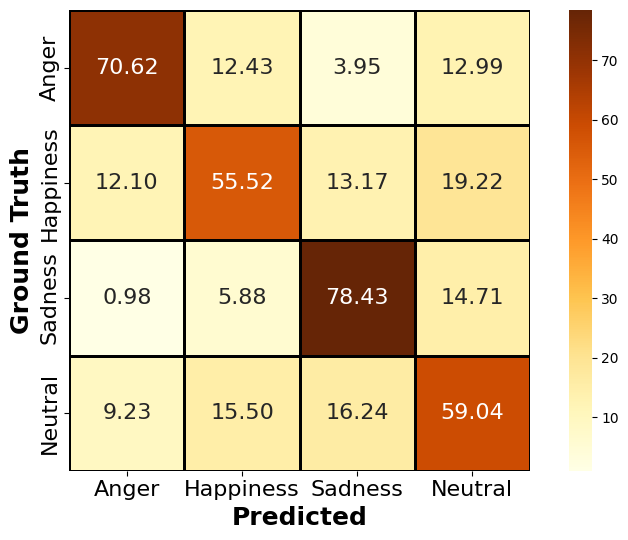

(0.6441586280814576, 0.647217257627076)

In [5]:
checkpoint_path = "/home/kuhaku/Code/EmotionClassification/code/3m-ser-private/scripts/checkpoints/3m-ser_roberta_wav2vec2_cml/20230820-232137"
opt_path = os.path.join(checkpoint_path,"opt.log")

ckpt_path = os.path.join(checkpoint_path,"weights/checkpoint_919_3428000.pt")
opt = Config()
opt.load(opt_path)
    
# Set dataset path
opt.data_root="/home/kuhaku/Code/EmotionClassification/code/3m-ser-private/scripts/data/IEMOCAP/"

# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
eval_svm(opt, ckpt_path, tokenizer)